# 1 损失函数

## 1.1 MSE

In [1]:
import torch
from torch.nn import MSELoss #Class

In [2]:
yhat = torch.randn(size=(50,),dtype=torch.float32)
y = torch.randn(size=(50,),dtype=torch.float32)

In [3]:
criterion = MSELoss(reduction = "sum")
# MSEloss(reduction = "mean"/"sum") #MSE #SSE

In [4]:
loss = criterion(yhat,y)

In [6]:
loss

tensor(86.6319)

## 1.2 二分类交叉熵

### 1.2.1 手动实现

$L(w) = \sum_{i=1}^m(y_i*ln(\sigma_i) + (1-y_i)*ln(1-\sigma_i))$

In [7]:
m = 3*pow(10,3)

torch.random.manual_seed(420)
X = torch.rand((m,4),dtype=torch.float32)
w = torch.rand((4,1),dtype=torch.float32)
y = torch.randint(low=0,high=2,size=(m,1),dtype=torch.float32)
zhat = torch.mm(X,w)
sigma = torch.sigmoid(zhat)

In [8]:
loss  = -(1/m) * sum(y * torch.log(sigma) + (1-y) * torch.log(1-sigma))

In [9]:
loss

tensor([0.7962])

注意，在写损失函数这样的复杂函数时，除了普通的加减乘除以外的全部计算，都要使用torch中的函数，因为tensor的运算速度是远远超过普通Python代码，甚至是NumPy的。你可以试着比较在样本量为300W时，以下两行代码运行的时间差异

In [27]:
import time
import numpy as np

In [23]:
m = 3 * pow(10, 5)

In [41]:
X = torch.rand((m, 4), dtype=torch.float32)
w = torch.rand((4, 1), dtype=torch.float32)

In [43]:
y = torch.randint(low=0, high=2, size=(m,1), dtype=torch.float32)

In [44]:
y

tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]])

In [24]:
X = torch.rand((m,4),dtype=torch.float32)
w = torch.rand((4,1),dtype=torch.float32)
y = torch.randint(low=0,high=2,size=(m,1),dtype=torch.float32)
zhat = torch.mm(X,w)
sigma = torch.sigmoid(zhat)

python原生

In [25]:
start = time.time() #捕获现在的时间
loss1 = -(1/m)*sum(y*torch.log(sigma) + (1-y)*torch.log(1-sigma))
now = time.time() #以秒计
print(now - start)

1.0851020812988281


torch

In [38]:
start = time.time()
loss2 = -(1/m)*torch.sum(y*torch.log(sigma) + (1-y)*torch.log(1-sigma))
now = time.time() #以秒计
print(now - start)

0.001994609832763672


numpy

In [39]:
# 2种转成Numpy的写法
np_sigma = torch.sigmoid(zhat).numpy() 
np_y = np.array(y)

In [40]:
start = time.time()
loss3 = - (1/m) * np.sum(np_y*np.log(np_sigma) + (1-np_y)*np.log(1-np_sigma))
now = time.time()
print(now - start)

0.003989219665527344


### 1.2.2 交叉熵实现

有nn中的2个，还有functional库中的2个，推荐nn.BCEWithLogitsLoss

In [48]:
import torch.nn as nn

In [49]:
criterion = nn.BCELoss(reduction = "mean") # none sum mean
loss = criterion(sigma,y)
loss

tensor(0.7608)

In [51]:
# pytorch官方更加推荐，因为内置的sigmoid函数可以让精度问题被缩小
criterion2 = nn.BCEWithLogitsLoss(reduction = "mean")
loss = criterion2(zhat, y)
loss

tensor(0.7608)

In [52]:
from torch.nn import functional as F
#直接调用functional库中的计算函数
F.binary_cross_entropy_with_logits(zhat,y)

tensor(0.7608)

In [53]:
F.binary_cross_entropy(sigma,y)

tensor(0.7608)

## 1.3 多分类交叉熵

二分类单样本使用这样的表示：$P = (\hat y_i|x_i,w) = P_1^{y_i}*P_0^{1-y_i}$

多分类单样本使用这的表示：$P = (\hat y_i|x_i,w) = P_1^{y_{i(k=1)}}*P_2^{y_{i(k=2)}}*...*P_k^{y_{i(k=K)}}$

由于仅为真实类别时才会有结果，所以可以简化为：$P = (\hat y_i|x_i,w) = P_j^{y_{i(k=j)}}$

多样本下的损失函数是：$L(w) = - \sum_{i=1}^my_{i(k=j)}ln\sigma_i$  
$ln\sigma_i$是对softmax计算的结果取Ln  
$- \sum_{i=1}^my_{i(k=j)}$是负对数似然函数NLLLoss：Negative Log Likelihood function

In [54]:
import torch
import torch.nn as nn

In [55]:
m = 3 * pow(10, 3)

In [75]:
torch.random.manual_seed(420)
X = torch.rand((m, 4), dtype=torch.float32)
w = torch.rand((4, 3), dtype=torch.float32)
y = torch.randint(low=0, high=3, size=(m,), dtype=torch.float32)

In [76]:
z_hat = torch.mm(X, w)

In [77]:
logsm = nn.LogSoftmax(dim=1)
log_sigma = logsm(z_hat)
log_sigma

tensor([[-1.1139, -0.8802, -1.3585],
        [-1.0558, -0.8982, -1.4075],
        [-1.0920, -1.0626, -1.1430],
        ...,
        [-1.0519, -0.9180, -1.3805],
        [-1.0945, -1.1219, -1.0798],
        [-1.0276, -0.8891, -1.4649]])

In [78]:
y

tensor([2., 2., 2.,  ..., 2., 2., 2.])

In [79]:
criterion = nn.NLLLoss() #实例化
#由于交叉熵损失需要将标签转化为独热形式，因此不接受浮点数作为标签的输入
#对NLLLoss而言，需要输入logsigma
criterion(log_sigma, y.long())

tensor(1.1147)

用nn的更快

In [80]:
criterion = nn.CrossEntropyLoss()

In [81]:
criterion(z_hat, y.long())

tensor(1.1147)

# 2 反向传播和迭代

## 2.1 自动求导

In [82]:
import torch

In [83]:
x = torch.tensor(1,requires_grad=True, dtype=torch.float32)

In [84]:
z = x**2

In [85]:
y = torch.tensor(2,requires_grad=False, dtype=torch.float32)

In [86]:
sigma = torch.sigmoid(z) 

In [87]:
loss = -(y*torch.log(sigma) + (1-y)*torch.log(1-sigma))

In [88]:
torch.autograd.grad(loss,x)

(tensor(-2.5379),)

## 2.2 搭建网络

In [97]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss as CEL
from torch.nn import functional as F

In [89]:
#确定数据
torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32) * 100
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)

In [90]:
class Model(nn.Module):
    def __init__(self, in_features=40, out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 13, bias=False)
        self.linear2 = nn.Linear(13, 8, bias=False)
        self.output = nn.Linear(8, out_features, bias=True)
    def forward(self, x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        z_hat = self.output(sigma2)
        return z_hat

In [93]:
input_ = X.shape[1]
output_ = len(y.unique())

In [94]:
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)

In [111]:
zhat = net.forward(X)

In [112]:
#定义损失函数
criterion = CEL()

In [113]:
loss = criterion(zhat, y.long())

In [114]:
loss

tensor(1.1559, grad_fn=<NllLossBackward>)

In [115]:
net.linear1.weight.grad #还没有梯度

tensor([[-6.0588e-04, -1.4974e-04, -7.3415e-04, -7.7351e-05, -2.6140e-04,
         -1.1693e-04, -6.6626e-04, -5.1727e-04, -1.8854e-04, -8.5235e-05,
         -1.5836e-04, -3.0359e-04, -1.8416e-04, -6.5027e-04, -2.1789e-04,
         -1.3007e-04, -2.6011e-04, -8.8230e-06, -1.9348e-04, -1.7094e-04],
        [ 2.0197e-02, -1.9837e-03,  2.4011e-02,  2.0821e-03,  1.0392e-02,
          7.1134e-03,  1.2124e-02,  7.9953e-03,  2.9962e-02,  1.8190e-02,
          1.2186e-02,  1.5038e-02,  2.7777e-02,  2.3854e-03,  1.7961e-02,
          1.9643e-02,  3.5274e-02,  2.0755e-02,  3.3555e-03,  1.5672e-03],
        [-2.0935e-02,  1.5948e-02,  6.0700e-03,  1.4997e-02,  8.6460e-03,
          1.9749e-03,  1.8516e-02,  1.2732e-02, -1.1614e-02,  2.3176e-03,
         -5.3246e-03,  1.2712e-02, -5.8676e-03, -8.9849e-03, -1.0081e-02,
          1.6878e-02, -2.0688e-02, -1.7009e-02,  4.2748e-03, -2.4894e-03],
        [-2.6928e-02, -2.1060e-02, -1.6663e-02, -3.1295e-02, -2.4752e-02,
         -3.2839e-02, -1.9562e-02, 

In [116]:
#与可以重复进行的正向传播不同，一次正向传播后，反向传播只能进行一次
#如果希望能够重复进行反向传播，可以在进行第一次反向传播的时候加上参数retain_graph
loss.backward(retain_graph=True)

In [117]:
net.linear1.weight.grad

tensor([[-9.0882e-04, -2.2461e-04, -1.1012e-03, -1.1603e-04, -3.9210e-04,
         -1.7540e-04, -9.9939e-04, -7.7591e-04, -2.8282e-04, -1.2785e-04,
         -2.3754e-04, -4.5538e-04, -2.7624e-04, -9.7540e-04, -3.2683e-04,
         -1.9511e-04, -3.9017e-04, -1.3234e-05, -2.9022e-04, -2.5642e-04],
        [ 3.0296e-02, -2.9756e-03,  3.6016e-02,  3.1232e-03,  1.5588e-02,
          1.0670e-02,  1.8185e-02,  1.1993e-02,  4.4943e-02,  2.7284e-02,
          1.8279e-02,  2.2556e-02,  4.1665e-02,  3.5781e-03,  2.6942e-02,
          2.9465e-02,  5.2911e-02,  3.1132e-02,  5.0333e-03,  2.3508e-03],
        [-3.1402e-02,  2.3921e-02,  9.1050e-03,  2.2496e-02,  1.2969e-02,
          2.9623e-03,  2.7773e-02,  1.9098e-02, -1.7421e-02,  3.4764e-03,
         -7.9870e-03,  1.9068e-02, -8.8015e-03, -1.3477e-02, -1.5122e-02,
          2.5317e-02, -3.1032e-02, -2.5513e-02,  6.4122e-03, -3.7341e-03],
        [-4.0392e-02, -3.1590e-02, -2.4995e-02, -4.6943e-02, -3.7128e-02,
         -4.9258e-02, -2.9343e-02, 

In [118]:
net.linear1.weight.shape

torch.Size([13, 20])

In [119]:
loss.backward()

## 2.3 动量法

### 2.3.1 手动实现

In [120]:
#在这里，我们的数据是生成的随机数，为了让大家看出效果，所以我才设置了步长为10，正常不会使用这么大的步长
#步长、学习率的英文是learning rate，所以常常简写为lr
lr = 10
dw = net.linear1.weight.grad
w = net.linear1.weight.data
#对任意w可以有
w -= lr * dw

普通梯度下降就是在重复正向传播、计算梯度、更新权重的过程，但这个过程往往非常漫长。如大家所见，步长设置为0.001时，我们看不到w任何的变化，只有当步长设置得非常巨大，我们才能够看到一些改变，但在之前的课程中我们说过，巨大的步长可能会让我们跳过真正的最小值，所以我们无法将步长设置得很大，无论如何，梯度下降都是一个缓慢的过程。在这个基础上，我们提出了加速迭代的数个方法，其中一个很关键的方法，就是使用动量Momentum。

In [123]:
# v(t) = gamma * v(t-1)  - lr * dw
# w(t+1) = w(t) + v(t)

lr = 0.1
gamma = 0.9
dw = net.linear1.weight.grad
w = net.linear1.weight.data

In [124]:
#t = 1，走第一步，进行首次迭代的时候，需要一个v0
v = torch.zeros(dw.shape[0], dw.shape[1])
v = gamma * v - lr * dw
w += v

### 2.3.2 torch.optim实现

In [125]:
##导入库
#确定数据、超参数的确定（lr，gamma）
#定义伸进网络的架构类Model，类Model需要输入的参数
##实例化神经网络的类 - 让神经网络准备好进行正向传播
#定义损失函数
#定义优化算法

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

#确定数据

torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32) * 100
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)

In [126]:
lr = 0.1
gamma = 0.9

In [127]:
#定义神经网路的架构
"""
注意：这是一个三分类的神经网络，因此我们需要调用的损失函数多分类交叉熵函数CEL
CEL类已经内置了softmax功能，因此我们需要修改一下网络架构，删除forward函数中输出层上的softmax函数，并将最终的输出修改为zhat
"""
class Model(nn.Module):
    def __init__(self,in_features=10,out_features=2):
        super(Model,self).__init__() #super(请查找这个类的父类，请使用找到的父类替换现在的类)
        self.linear1 = nn.Linear(in_features,13,bias=True) #输入层不用写，这里是隐藏层的第一层
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)
        
    def forward(self, x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat

In [128]:
input_ = X.shape[1] #特征的数目
output_ = len(y.unique()) #分类的数目

In [129]:
#实例化神经网络类
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)

In [130]:
net.parameters() #一次性导出现有神经网络架构下全部的权重和截距

<generator object Module.parameters at 0x0000029D606F53C8>

In [131]:
#定义损失函数
criterion = nn.CrossEntropyLoss()

In [132]:
#定义优化算法
opt = optim.SGD(net.parameters()#需要进行迭代的权重
                ,lr = lr
                ,momentum = gamma
               )

In [ ]:
#向前传播
#本轮向前传播的损失函数值
#反向传播 - 得到了梯度
#更新权重（和动量）
#清空梯度 - 清除原来计算出来的，基于上一个点的坐标计算的梯度

In [133]:
X.shape

torch.Size([500, 20])

In [136]:
zhat = net.forward(X) #向前传播
loss = criterion(zhat,y.reshape(500).long()) #损失函数值
loss.backward() #反向传播
opt.step() #更新权重w，从这一瞬间开始，坐标点就发生了变化，所有的梯度必须重新计算
opt.zero_grad() #清除原来储存好的，基于上一个坐标点计算的梯度，为下一次计算梯度腾出空间

print(loss)
print(net.linear1.weight.data[0][:10])

tensor(1.1005, grad_fn=<NllLossBackward>)
tensor([ 0.1365, -0.1346,  0.2127, -0.1776, -0.0683, -0.1541,  0.1723,  0.0838,
        -0.1116, -0.1730])


## 2.4 batch

### 2.4.1 MSGD介绍

MSGD:
- 优点：①能找到全局最小值；②计算速度加快
- 缺点：迭代次数不清楚

在深度学习中，如果梯度下降的每次迭代都使用全部数据，将会非常耗费计算资源，且样本量越大，计算开销越高。虽然PyTorch被设计成天生能够处理巨量数据，但我们还是需要在数据量这一点上下功夫。这一节，我们开始介绍小批量随机梯度下降（mini-batch stochasticgradient descent，简写为mini-batch SGD）。


小批量随机梯度下降是深度学习入门级的优化算法（梯度下降是入门级之下的），其求解与迭代流程与传统梯度下降（GD）基本一致，不过二者在迭代权重时使用的数据这一点上存在巨大的不同。传统梯度下降在每次进行权重迭代（即循环）时都使用全部数据，每次迭代所使用的数据也都一致。而minibatch SGD是每次迭代前都会从整体采样一批固定数目的样本组成批次（batch）B，并用B中的样本进行梯度计算，以减少样本量。


为什么会选择mini-batch SGD作为神经网络的入门级优化算法呢？有两个比较主流的原因。第一个是，比起传统梯度下降，mini-batch SGD更可能找到全局最小值。

传统梯度下降是每次迭代时都使用全部数据的梯度下降，所以每次使用的数据是一致的，因此梯度向量的方向和大小都只受到权重 的影响，所以梯度方向的变化相对较小，很多时候看起来梯度甚至是指向一个方向（如上图所示）。这样带来的优势是可以使用较大的步长，快速迭代直到找到最小值。但是缺点也很明显，由于梯度方向不容易发生巨大变化，所以一旦在迭代过程中落入局部最优的范围，传统梯度下降就很难跳出局部最优，再去寻找全局最优解了。

![](./pics/损失函数和优化器/MSGD.png)

而mini-batch SGD在每次迭代前都会随机抽取一批数据，所以每次迭代时带入梯度向量表达式的数据是不同的，梯度的方向同时受到系数 和带入的训练数据的影响，**因此每次迭代时梯度向量的方向都会发生较大变化**。并且，当抽样的数据量越小，本次迭代中使用的样本数据与上一次迭代中使用的样本数据之间的差异就可能越大，这也导致本次迭代中梯度的方向与上一次迭代中梯度的方向有巨大差异。所以对于mini-batch SGD而言，它的梯度下降路线看起来往往是曲折的折线（如上图所示）。

极端情况下，当我们每次随机选取的批量中只有一个样本时，梯度下降的迭代轨迹就会变得异常不稳定（如上图所示）。我们称这样的梯度下降为随机梯度下降（stochastic gradient descent，SGD）。mini-batch SGD的优势是算法不会轻易陷入局部最优，由于每次梯度向量的方向都会发生巨大变化，因此一旦有机会，算法就能够跳出局部最优，走向全局最优（当然也有可能是跳出一个局部最优，走向另一个局部最优）。**不过缺点是，需要的迭代次数变得不明**。如果最开始就在全局最优的范围内，那可能只需要非常少的迭代次数就收敛，但是如果最开始落入了局部最优的范围，或全局最优与局部最优的差异很小，那可能需要花很长的时间、经过很多次迭代才能够收敛，毕竟不断改变的方向会让迭代的路线变得曲折。

从整体来看，为了mini-batch SGD这“不会轻易被局部最优困住”的优点，我们在神经网络中使用它作为优化算法（或优化算法的基础）。当然，还有另一个流传更广、更为认知的理由支持我们使用minibatch SGD：mini-batch SGD可以提升神经网络的计算效率，让神经网络计算更快。为了解决计算开销大的问题，我们要使用mini-batch SGD。考虑到可以从全部数据中选出一部分作为全部数据的“近似估计"，然后用选出的这一部分数据来进行迭代，每次迭代需要计算的数据量就会更少，计算消耗也会更少，因此神经网络的速度会提升。当然了，这并不是说使用1001个样本进行迭代一定比使用1000个样本进行迭代速度要慢，而是指每次迭代中计算上十万级别的数据，会比迭代中只计算一千个数据慢得多。

epoch是衡量训练数据被使用次数的单位，一个epoch表示优化算法将全部训练数据都使用了一次。它与梯度下降中的迭代次数有非常深的关系，我们常使用“完成1个epoch需要n次迭代“这样的语言。

In [137]:
epoch = 60 #请让神经网络学习60次全部数据
batch = 10 #把全数据X划分为10个batch

for epochs in range(epoch):
    for batch in range(batch):
        zhat = net.forward(X) #最后一个线性层的输出结果，向前传播
        loss = criterion(zhat, y.reshape(500).long()) #计算损失函数
        loss.backward()
        opt.step() #步子，走一步，更新权重w，更新动量v
        opt.zero_grad()

### 2.4.2 TenserDataset和DataLoader

需要对数据进行采样、分割等操作。在PyTorch中，操作数据所需要使用的模块是torch.utils，其中utils.data类下面有大量用来执行数据预处理的工具。在MBSGD中，我们需要将数据划分为许多组特征张量+对应标签的形式，因此最开始我们要将数据的特征张量与标签打包成一个对象。之前我们提到过，深度学习中的特征张量维度很少是二维，因此其特征张量与标签几乎总是分开的，不像机器学习中标签常常出现在特征矩阵的最后一列或第一列。在我们之前的例子中，我们是单独生成了标签与特征张量，所以也需要合并，如果你的数据本来就是特征张量与标签在同一个张量中，那你可以跳过这一步。

合并张量与标签，我们所使用的类是utils.data.TensorDataset，这个功能类似于python中的zip，可以将最外面的维度一致的tensor进行打包，也就是将第一个维度一致的tensor进行打包。我们来看一下：

In [140]:
import torch
from torch.utils.data import TensorDataset
a = torch.randn(500,2,3)
b = torch.randn(500,3,4,5)
c = torch.randn(500,1)
TensorDataset(a,b,c)[0]

(tensor([[ 0.6375, -2.2982, -0.1133],
         [ 0.5568,  0.2281,  0.2848]]),
 tensor([[[-0.2488,  0.9710, -0.0898, -1.6021,  0.4668],
          [-1.1830, -0.6481, -0.2827, -0.8406,  1.2424],
          [ 0.4588, -0.7573, -1.3363,  0.0340,  0.0669],
          [ 0.7278,  1.5799, -0.1209,  0.5723,  0.5374]],
 
         [[-0.4636,  0.0549, -0.5719, -0.0037,  0.5953],
          [-0.3521,  0.4009,  1.1674, -0.7637,  0.8819],
          [-0.8994, -2.3747,  1.2722, -0.5038, -0.4691],
          [-0.0265,  1.6925,  0.7167,  0.5892, -0.4352]],
 
         [[-0.7066,  0.2174,  0.0977, -0.7980, -1.9867],
          [ 0.0781,  0.1157, -0.1451, -2.1414,  0.4255],
          [ 1.0590, -0.8353, -0.4461, -0.2727, -1.1807],
          [-1.2888, -0.1733, -0.3328,  0.4281, -1.7653]]]),
 tensor([0.4627]))

In [145]:
# 和zip还是不一样，实际上没有并到一起，但是在torch的训练时会一组一组读取
for i in zip([1,2,3], [4,5,6]):
    print(i)

(1, 4)
(2, 5)
(3, 6)


In [146]:
#试试看合并a与c，我们一般合并特征张量与标签，就是这样合并的
TensorDataset(a,c)[0]

(tensor([[ 0.6375, -2.2982, -0.1133],
         [ 0.5568,  0.2281,  0.2848]]),
 tensor([0.4627]))

In [147]:
#如果合并的tensor的最外层的维度不相等
c = torch.randn(300,1)
TensorDataset(a,c)[0]

AssertionError: Size mismatch between tensors

当我们将数据打包成一个对象之后，我们需要使用划分小批量的功能DataLoader。DataLoader是处理训练前专用的功能，它可以接受任意形式的数组、张量作为输入，并把他们一次性转换为神经网络可以接入的tensor。

In [148]:
from torch.utils.data import DataLoader

In [150]:
b = torch.randn(500,3,4,5)
c = torch.randn(500,1)
data = TensorDataset(b,c)

In [151]:
for x in DataLoader(data):
    print(x)
    break

[tensor([[[[ 6.7865e-01, -5.5162e-01,  2.1791e+00, -2.4237e-02, -1.4930e+00],
          [-1.6076e+00,  5.5992e-01,  7.1593e-01, -5.9433e-01, -1.3133e+00],
          [ 3.3145e-01,  3.4970e-01,  1.2913e+00,  4.4500e-01,  6.8841e-01],
          [-9.9585e-01, -1.2249e+00,  3.0657e-01, -2.5904e+00, -2.9265e-01]],

         [[ 4.1238e-01,  1.0195e+00,  4.4412e-01,  1.0168e-01, -4.7166e-01],
          [ 4.0492e-01,  1.7901e-01,  2.9355e-01,  7.0473e-01,  4.4794e-01],
          [-5.5782e-01, -1.2660e-03,  1.9333e-01,  1.7140e+00, -1.0123e-01],
          [ 6.7576e-01,  5.3580e-01, -6.0712e-01, -8.5088e-01,  1.3299e+00]],

         [[-2.1354e-02, -1.1275e+00,  7.4320e-01, -1.4692e+00,  7.7091e-03],
          [ 1.1615e-01,  1.4128e+00,  1.2669e+00, -2.5619e-01, -1.5276e+00],
          [-5.8195e-01, -4.7048e-01, -1.3230e+00, -4.6937e-01, -1.3707e+00],
          [ 2.9066e-01, -6.8272e-01,  9.0702e-01, -5.1144e-01, -1.5555e-01]]]]), tensor([[-0.0907]])]


In [152]:
bs = 120

In [153]:
dataset = DataLoader(data
          , batch_size = bs
          , shuffle = True #划分小批量之前请随机打乱我们的数据
          , drop_last = True #你要舍弃最后一个batch吗？
          )

In [154]:
for i in dataset:
    print(i[0].shape)

torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])


In [155]:
len(dataset) #一共有多少个batch

4

In [156]:
dataset

In [157]:
dataset.dataset[0] #单个样本

(tensor([[[ 6.7865e-01, -5.5162e-01,  2.1791e+00, -2.4237e-02, -1.4930e+00],
          [-1.6076e+00,  5.5992e-01,  7.1593e-01, -5.9433e-01, -1.3133e+00],
          [ 3.3145e-01,  3.4970e-01,  1.2913e+00,  4.4500e-01,  6.8841e-01],
          [-9.9585e-01, -1.2249e+00,  3.0657e-01, -2.5904e+00, -2.9265e-01]],
 
         [[ 4.1238e-01,  1.0195e+00,  4.4412e-01,  1.0168e-01, -4.7166e-01],
          [ 4.0492e-01,  1.7901e-01,  2.9355e-01,  7.0473e-01,  4.4794e-01],
          [-5.5782e-01, -1.2660e-03,  1.9333e-01,  1.7140e+00, -1.0123e-01],
          [ 6.7576e-01,  5.3580e-01, -6.0712e-01, -8.5088e-01,  1.3299e+00]],
 
         [[-2.1354e-02, -1.1275e+00,  7.4320e-01, -1.4692e+00,  7.7091e-03],
          [ 1.1615e-01,  1.4128e+00,  1.2669e+00, -2.5619e-01, -1.5276e+00],
          [-5.8195e-01, -4.7048e-01, -1.3230e+00, -4.6937e-01, -1.3707e+00],
          [ 2.9066e-01, -6.8272e-01,  9.0702e-01, -5.1144e-01, -1.5555e-01]]]),
 tensor([-0.0907]))

In [158]:
dataset.dataset[0][0]

tensor([[[ 6.7865e-01, -5.5162e-01,  2.1791e+00, -2.4237e-02, -1.4930e+00],
         [-1.6076e+00,  5.5992e-01,  7.1593e-01, -5.9433e-01, -1.3133e+00],
         [ 3.3145e-01,  3.4970e-01,  1.2913e+00,  4.4500e-01,  6.8841e-01],
         [-9.9585e-01, -1.2249e+00,  3.0657e-01, -2.5904e+00, -2.9265e-01]],

        [[ 4.1238e-01,  1.0195e+00,  4.4412e-01,  1.0168e-01, -4.7166e-01],
         [ 4.0492e-01,  1.7901e-01,  2.9355e-01,  7.0473e-01,  4.4794e-01],
         [-5.5782e-01, -1.2660e-03,  1.9333e-01,  1.7140e+00, -1.0123e-01],
         [ 6.7576e-01,  5.3580e-01, -6.0712e-01, -8.5088e-01,  1.3299e+00]],

        [[-2.1354e-02, -1.1275e+00,  7.4320e-01, -1.4692e+00,  7.7091e-03],
         [ 1.1615e-01,  1.4128e+00,  1.2669e+00, -2.5619e-01, -1.5276e+00],
         [-5.8195e-01, -4.7048e-01, -1.3230e+00, -4.6937e-01, -1.3707e+00],
         [ 2.9066e-01, -6.8272e-01,  9.0702e-01, -5.1144e-01, -1.5555e-01]]])

In [159]:
dataset.dataset[0][1]

tensor([-0.0907])

In [160]:
dataset.batch_size #查看现有的batch_size

120

对于小批量随机梯度下降而言，我们一般这样使用TensorDataset与DataLoader:


In [161]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
torch.manual_seed(420)
X = torch.rand((50000,20),dtype=torch.float32) * 100 #要进行迭代了，增加样本数量
y = torch.randint(low=0,high=3,size=(50000,1),dtype=torch.float32)
epochs = 4
bs = 4000
data = TensorDataset(X,y)
batchdata = DataLoader(data, batch_size=bs, shuffle = True)
len(batchdata) #查看具体被分了多少个batch
#可以使用.datasets查看数据集相关的属性
len(batchdata.dataset) #总共有多少数据
batchdata.dataset[0] #查看其中一个样本
batchdata.dataset[0][0]#一个样本的特征张量
batchdata.dataset[0][1]#一个样本的标签
#属性batch_size，查看现在的batch_size是多少
batchdata.batch_size

4000

In [163]:
#我们在迭代的时候，常常这样使用：
for batch_idx, (x,y) in enumerate(batchdata):
    #sigma = net(x)
    #loss = lossfn(sigma, y)
    #loss.backward()
    #opt.step()
    #opt.zero_grad()
    print(x.shape)
    print(y.shape)
    print(x,y)
    if batch_idx == 2:
        break #为了演示用，所以打断，在正常的循环里是不会打断的

torch.Size([4000, 20])
torch.Size([4000, 1])
tensor([[24.4804, 88.4311, 90.7928,  ..., 66.4178, 91.6913, 86.2798],
        [11.3812, 60.5861, 85.4907,  ..., 64.7298, 50.4029, 17.6171],
        [36.8907, 88.6091, 51.1426,  ..., 26.4396, 28.1520, 25.4440],
        ...,
        [66.3327, 92.1414,  8.1029,  ..., 81.5257, 89.6613, 32.9947],
        [66.0353, 96.5900, 93.1599,  ..., 93.1735, 66.7829, 39.6237],
        [36.9158,  9.0684, 23.7006,  ...,  0.9979, 20.7019, 47.3606]]) tensor([[2.],
        [0.],
        [1.],
        ...,
        [2.],
        [1.],
        [2.]])
torch.Size([4000, 20])
torch.Size([4000, 1])
tensor([[4.6021e+00, 9.2652e+01, 2.4196e+01,  ..., 4.8241e+01, 5.2453e+01,
         2.9459e+01],
        [2.4702e+01, 1.6894e+01, 8.5195e+01,  ..., 4.7593e+01, 7.8934e+01,
         6.3864e+01],
        [9.4442e+01, 4.5311e+01, 7.7364e+01,  ..., 8.3494e+01, 4.2660e+01,
         3.3664e+01],
        ...,
        [7.5925e+01, 5.5428e+01, 7.8092e+01,  ..., 2.2697e+01, 2.2982e+00,

# 3 MINST-FASHION

本节课我们讲解了神经网络使用小批量随机梯度下降进行迭代的流程，现在我们要整合本节课中所有的
代码实现一个完整的训练流程。首先要梳理一下整个流程：
- 1）设置步长 ，动量值 ，迭代次数 ，batch_size等信息，（如果需要）设置初始权重
- 2）导入数据，将数据切分成batches
- 3）定义神经网络架构
- 4）定义损失函数 ，如果需要的话，将损失函数调整成凸函数，以便求解最小值
- 5）定义所使用的优化算法
- 6）开始在epoches和batch上循环，执行优化算法：
 6.1）调整数据结构，确定数据能够在神经网络、损失函数和优化算法中顺利运行
 6.2）完成向前传播，计算初始损失
 6.3）利用反向传播，在损失函数 上对每一个 求偏导数
 6.4）迭代当前权重
 6.5）清空本轮梯度
 6.6）完成模型进度与效果监控
- 7）输出结果

## 3.1 导库，设置各种初始值

In [166]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#确定数据、确定优先需要设置的值
lr = 0.15
gamma = 0
epochs = 10
bs = 128

## 3.2 导入数据，分割小批量

下载到了自定义目录的FashionMNIST中，大小134MB

In [167]:
import torchvision
import torchvision.transforms as transforms #处理数据模块

In [171]:
mnist = torchvision.datasets.FashionMNIST(root = "./FashionMNIST" #你的计算机上的某个目录
                                          , download = True
                                          , train = True
                                          , transform = transforms.ToTensor()
                                         ) #实例化数据

11.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

31.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

50.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

70.6%IOPub

Extracting ./FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



100.6%


Extracting ./FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



66.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



119.3%
F:\conda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\FashionMNIST\raw

Processing...
Done!


In [174]:
mnist #对于数据的一个说明

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [175]:
len(mnist)

60000

In [176]:
mnist.data.shape #特征张量

torch.Size([60000, 28, 28])

In [177]:
mnist.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [178]:
mnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [179]:
import matplotlib.pyplot as plt
import numpy

In [180]:
mnist[0][0].shape

torch.Size([1, 28, 28])

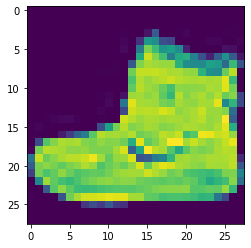

In [181]:
plt.imshow(mnist[0][0].view(28,28).numpy()); #imageshow

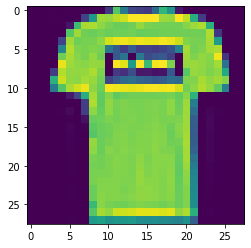

In [182]:
plt.imshow(mnist[1][0].view(28,28).numpy());

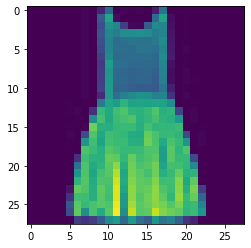

In [183]:
plt.imshow(mnist[30001][0].view(28,28).numpy());

In [187]:
batchdata = DataLoader(mnist
                       ,batch_size = bs
                       ,shuffle = True)

In [188]:
for x,y in batchdata:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [17]:
#(500,20) - 20
#x - 四维 （128,28*28）

In [189]:
input_ = mnist.data[0].numel() #请问这个张量中总共有多少元素呢？

In [191]:
output_ = len(mnist.targets.unique())

## 3.3 定义神经网络的架构

In [194]:
class Model(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features,1280,bias=False)
        self.output = nn.Linear(1280,out_features, bias=False)
    
    def forward(self, x):
        x = x.view(-1,28*28)
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = F.log_softmax(self.output(sigma1),dim=1)
        return sigma2

In [198]:
#view(-1,) #需要对数据结构进行一个改变，-1作为占位符，表示请pytorch帮助我们自动计算-1这个位置的维度应是多少
x = torch.randn(30,40)
x = x.view(-1,20)
x.shape

torch.Size([60, 20])

In [28]:
#定义损失函数、优化算法、梯度下降的流程
#定义一个训练函数
#128

In [212]:
len(mnist) / bs

468.75

In [199]:
len(batchdata)-1 #469个batch

468

In [29]:
469/125

3.752

## 3.4 定义训练函数

In [200]:
def fit(net,bacthdata,lr=0.01, epochs=5, gamma = 0):
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(),lr=lr,momentum = gamma)
    correct = 0 #循环开始之前，预测正确的值为0
    samples = 0 #循环开始之前，模型一个样本都没有见过
    for epoch in range(epochs): #全数据被训练几次
        for batch_idx,(x,y) in enumerate(batchdata):
            y = y.view(x.shape[0]) #降维
            sigma = net.forward(x) #正向传播
            loss = criterion(sigma,y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            #求解准确率，全部判断正确的样本数量/已经看过的总样本量
            yhat = torch.max(sigma, 1)[1] #torch.max函数结果中的索引为1的部分
            correct += torch.sum(yhat == y)
            samples += x.shape[0]
            #每训练一个batch的数据，模型见过的数据就会增加x.shape[0]
            
            if (batch_idx + 1) % 125 == 0 or batch_idx == len(batchdata)-1: #每N个batch我就打印一次
                print("Epoch{}:[{}/{}({:.0f}%)],Loss:{:.6f},Accuracy:{:.3f}".format(
                    epoch+1
                    ,samples
                    ,epochs*len(batchdata.dataset)
                    ,100*samples/(epochs*len(batchdata.dataset))
                    ,loss.data.item()
                    ,float(100*correct/samples)
                     ))
            #分子代表：已经查看过的数据有多少
            #分母代表：在现有的epochs设置，模型一共需要查看多少数据

In [213]:
print("实验一下，这里是值{}".format("A"))

实验一下，这里是值A


In [214]:
list = ["A","B","C"]

In [215]:
for x in enumerate(list):
    print(x)

(0, 'A')
(1, 'B')
(2, 'C')


In [216]:
l = torch.tensor([[0.3,0.4,0.25],[0.7,0.2,0.1]])

In [217]:
l

tensor([[0.3000, 0.4000, 0.2500],
        [0.7000, 0.2000, 0.1000]])

In [218]:
torch.max(l,1)[1] #softmax的预测标签

tensor([1, 0])

In [219]:
l = torch.tensor([True,False,True])

In [220]:
torch.sum(l) #True = 1, False = 0

tensor(2)

## 3.5 进行训练和评估

In [210]:
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)
fit(net,batchdata,lr=lr,epochs=epochs,gamma=gamma)

Epoch1:[16000/600000(3%)],Loss:0.727888,Accuracy:68.819
Epoch1:[32000/600000(5%)],Loss:0.513726,Accuracy:73.550
Epoch1:[48000/600000(8%)],Loss:0.459364,Accuracy:76.173
Epoch1:[60000/600000(10%)],Loss:0.563562,Accuracy:77.373
Epoch2:[76000/600000(13%)],Loss:0.433777,Accuracy:78.687
Epoch2:[92000/600000(15%)],Loss:0.363204,Accuracy:79.634
Epoch2:[108000/600000(18%)],Loss:0.443800,Accuracy:80.304
Epoch2:[120000/600000(20%)],Loss:0.442278,Accuracy:80.723
Epoch3:[136000/600000(23%)],Loss:0.543707,Accuracy:81.285
Epoch3:[152000/600000(25%)],Loss:0.354620,Accuracy:81.691
Epoch3:[168000/600000(28%)],Loss:0.526626,Accuracy:82.088
Epoch3:[180000/600000(30%)],Loss:0.411618,Accuracy:82.367
Epoch4:[196000/600000(33%)],Loss:0.350448,Accuracy:82.678
Epoch4:[212000/600000(35%)],Loss:0.345022,Accuracy:83.008
Epoch4:[228000/600000(38%)],Loss:0.474553,Accuracy:83.263
Epoch4:[240000/600000(40%)],Loss:0.324190,Accuracy:83.479
Epoch5:[256000/600000(43%)],Loss:0.317327,Accuracy:83.738
Epoch5:[272000/600000(4

我们现在已经完成了一个最基本的、神经网络训练并查看训练结果的代码，是不是感觉已经获得了很多支持呢？我们的模型最后得到的结果属于中规中矩，毕竟我们设置的网格结构只是最普通的全连接层，并且我们并没有对数据进行任何的处理或增强（在神经网络架构中，有被注释掉的两行关于batchnormalization的代码，取消注释，你会看到神经网络的准确率瞬间增加了5%，这是常用的处理之一）。已经成熟的、更加稳定的神经网络架构可以很轻易在MINST-FASHION数据集上获得99%的准确率，因此我们还有很长的路要走。从下节课开始，我们将学习更完整的训练流程，并学习神经网络性能与效果优化相关的更多内容。